In [1]:
# パッケージのインポート
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


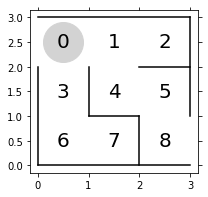

In [2]:
# 迷路の作成
fig = plt.figure(figsize=(3, 3))

# 壁
plt.plot([0, 3], [3, 3], color='k')
plt.plot([0, 3], [0, 0], color='k')
plt.plot([0, 0], [0, 2], color='k')
plt.plot([3, 3], [1, 3], color='k')
plt.plot([1, 1], [1, 2], color='k')
plt.plot([2, 3], [2, 2], color='k')
plt.plot([2, 1], [1, 1], color='k')
plt.plot([2, 2], [0, 1], color='k')

# 数字
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha='center', va='center')

# 円
circle, = plt.plot([0.5], [2.5], marker='o', color='#d3d3d3', markersize=40)

# 目盛りと枠の非表示
plt.tick_params(axis='both', which='both', bottom='off', top= 'off',
        labelbottom='off', right='off', left='off', labelleft='off')
plt.box('off')

In [3]:
# パラメータθの初期値の準備
theta_0 = np.array([
    [np.nan, 1, 1, np.nan], # 0 上,右,下,左
    [np.nan, 1, 1, 1], # 1
    [np.nan, np.nan, np.nan, 1], # 2
    [1, np.nan, 1, np.nan], # 3
    [1, 1, np.nan, np.nan], # 4
    [np.nan, np.nan, 1, 1], # 5
    [1, 1, np.nan, np.nan], # 6
    [np.nan, np.nan, np.nan, 1]]) # 7

In [4]:
# パラメータθを方策に変換
def get_pi(theta):
    # ソフトマックス関数で変換
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    exp_theta = np.exp(theta)
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
    pi = np.nan_to_num(pi)
    return pi

In [5]:
# パラメータθの初期値を方策に変換
pi_0 = get_pi(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


In [6]:
# 方策に従って行動を取得
def get_a(pi, s):
    # 方策の確率に従って行動を返す
    return np.random.choice([0, 1, 2, 3], p=pi[s])

In [7]:
# 行動に従って次の状態を取得
def get_s_next(s, a):
    if a == 0: # 上
        return s - 3
    elif a == 1: # 右
        return s + 1
    elif a == 2: # 下
        return s + 3
    elif a == 3: # 左
        return s - 1

In [8]:
# 1エピソード実行して履歴取得
def play(pi):
    s = 0 # 状態
    s_a_history = [[0, np.nan]] # 状態と行動の履歴
    
    # エピソード完了までループ
    while True:
        # 方策に従って行動を取得
        a = get_a(pi, s)
        
        # 行動に従って次の状態を取得
        s_next = get_s_next(s, a)
        
        # 履歴の更新
        s_a_history[-1][1] = a     
        s_a_history.append([s_next, np.nan]) 
        
        # 終了判定
        if s_next == 8:
            break
        else:
            s = s_next
            
    return s_a_history

In [9]:
# 1エピソードの実行と履歴の確認
s_a_history = play(pi_0)
print(s_a_history)
print('1エピソードのステップ数：{}'.format(len(s_a_history)+1))

[[0, 1], [1, 1], [2, 3], [1, 2], [4, 1], [5, 2], [8, nan]]
1エピソードのステップ数：8


In [10]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 学習係数
    total = len(s_a_history) - 1 # ゴールまでにかかった総ステップ数
    [s_count, a_count] = theta.shape # 状態数, 行動数

    # パラメータθの変化量の計算
    delta_theta = theta.copy()
    for i in range(0, s_count):
        for j in range(0, a_count):
            if not(np.isnan(theta[i, j])):
                # ある状態である行動を採る回数
                sa_ij = [sa for sa in s_a_history if sa == [i, j]]
                n_ij = len(sa_ij)

                # ある状態でなんらかの行動を採る回数
                sa_i = [sa for sa in s_a_history if sa[0] == i]
                n_i = len(sa_i)

                # パラメータθの変化量
                delta_theta[i, j] = (n_ij - pi[i, j] * n_i) / total

    # パラメータθの更新
    return theta + eta * delta_theta

In [11]:
stop_epsilon = 10**-4 # しきい値
theta = theta_0 # パラメータθ
pi = pi_0 # 方策

# エピソードを繰り返し実行して学習
for episode in range(10000):
    # 1エピソード実行して履歴取得
    s_a_history = play(pi)
    
    # パラメータθの更新
    theta = update_theta(theta, pi, s_a_history)
    
    # 方策の更新
    pi_new = get_pi(theta)
    
    # 方策の変化量
    pi_delta = np.sum(np.abs(pi_new-pi))
    pi = pi_new    
    
    # 出力
    print('エピソード: {}, ステップ： {}, 方策変化量: {:.4f}'.format(
        episode, len(s_a_history)-1, pi_delta))
    
    # 終了判定
    if pi_delta < stop_epsilon: # 方策の変化量がしきい値以下
        break

エピソード: 0, ステップ： 30, 方策変化量: 0.0146
エピソード: 1, ステップ： 14, 方策変化量: 0.0187
エピソード: 2, ステップ： 94, 方策変化量: 0.0054
エピソード: 3, ステップ： 48, 方策変化量: 0.0156
エピソード: 4, ステップ： 36, 方策変化量: 0.0042
エピソード: 5, ステップ： 122, 方策変化量: 0.0069
エピソード: 6, ステップ： 6, 方策変化量: 0.0323
エピソード: 7, ステップ： 36, 方策変化量: 0.0137
エピソード: 8, ステップ： 10, 方策変化量: 0.0343
エピソード: 9, ステップ： 128, 方策変化量: 0.0075
エピソード: 10, ステップ： 10, 方策変化量: 0.0289
エピソード: 11, ステップ： 42, 方策変化量: 0.0106
エピソード: 12, ステップ： 6, 方策変化量: 0.0318
エピソード: 13, ステップ： 50, 方策変化量: 0.0106
エピソード: 14, ステップ： 48, 方策変化量: 0.0120
エピソード: 15, ステップ： 4, 方策変化量: 0.0476
エピソード: 16, ステップ： 60, 方策変化量: 0.0116
エピソード: 17, ステップ： 10, 方策変化量: 0.0195
エピソード: 18, ステップ： 44, 方策変化量: 0.0123
エピソード: 19, ステップ： 14, 方策変化量: 0.0135
エピソード: 20, ステップ： 4, 方策変化量: 0.0470
エピソード: 21, ステップ： 6, 方策変化量: 0.0323
エピソード: 22, ステップ： 52, 方策変化量: 0.0105
エピソード: 23, ステップ： 18, 方策変化量: 0.0120
エピソード: 24, ステップ： 14, 方策変化量: 0.0194
エピソード: 25, ステップ： 4, 方策変化量: 0.0463
エピソード: 26, ステップ： 16, 方策変化量: 0.0235
エピソード: 27, ステップ： 24, 方策変化量: 0.0192
エピソード: 28, ステップ： 6, 方策変化量: 0.0321


エピソード: 246, ステップ： 8, 方策変化量: 0.0167
エピソード: 247, ステップ： 12, 方策変化量: 0.0234
エピソード: 248, ステップ： 14, 方策変化量: 0.0185
エピソード: 249, ステップ： 10, 方策変化量: 0.0170
エピソード: 250, ステップ： 4, 方策変化量: 0.0228
エピソード: 251, ステップ： 6, 方策変化量: 0.0153
エピソード: 252, ステップ： 16, 方策変化量: 0.0321
エピソード: 253, ステップ： 32, 方策変化量: 0.0145
エピソード: 254, ステップ： 30, 方策変化量: 0.0185
エピソード: 255, ステップ： 8, 方策変化量: 0.0167
エピソード: 256, ステップ： 10, 方策変化量: 0.0200
エピソード: 257, ステップ： 18, 方策変化量: 0.0200
エピソード: 258, ステップ： 4, 方策変化量: 0.0227
エピソード: 259, ステップ： 16, 方策変化量: 0.0195
エピソード: 260, ステップ： 8, 方策変化量: 0.0131
エピソード: 261, ステップ： 14, 方策変化量: 0.0203
エピソード: 262, ステップ： 4, 方策変化量: 0.0225
エピソード: 263, ステップ： 8, 方策変化量: 0.0269
エピソード: 264, ステップ： 18, 方策変化量: 0.0246
エピソード: 265, ステップ： 18, 方策変化量: 0.0140
エピソード: 266, ステップ： 8, 方策変化量: 0.0144
エピソード: 267, ステップ： 6, 方策変化量: 0.0218
エピソード: 268, ステップ： 4, 方策変化量: 0.0223
エピソード: 269, ステップ： 10, 方策変化量: 0.0187
エピソード: 270, ステップ： 64, 方策変化量: 0.0150
エピソード: 271, ステップ： 18, 方策変化量: 0.0135
エピソード: 272, ステップ： 4, 方策変化量: 0.0222
エピソード: 273, ステップ： 4, 方策変化量: 0.0218
エピソード

エピソード: 540, ステップ： 8, 方策変化量: 0.0089
エピソード: 541, ステップ： 6, 方策変化量: 0.0115
エピソード: 542, ステップ： 4, 方策変化量: 0.0083
エピソード: 543, ステップ： 10, 方策変化量: 0.0160
エピソード: 544, ステップ： 4, 方策変化量: 0.0083
エピソード: 545, ステップ： 6, 方策変化量: 0.0096
エピソード: 546, ステップ： 4, 方策変化量: 0.0082
エピソード: 547, ステップ： 4, 方策変化量: 0.0081
エピソード: 548, ステップ： 6, 方策変化量: 0.0095
エピソード: 549, ステップ： 14, 方策変化量: 0.0106
エピソード: 550, ステップ： 4, 方策変化量: 0.0080
エピソード: 551, ステップ： 4, 方策変化量: 0.0079
エピソード: 552, ステップ： 4, 方策変化量: 0.0078
エピソード: 553, ステップ： 4, 方策変化量: 0.0077
エピソード: 554, ステップ： 4, 方策変化量: 0.0077
エピソード: 555, ステップ： 4, 方策変化量: 0.0076
エピソード: 556, ステップ： 6, 方策変化量: 0.0108
エピソード: 557, ステップ： 6, 方策変化量: 0.0092
エピソード: 558, ステップ： 4, 方策変化量: 0.0075
エピソード: 559, ステップ： 4, 方策変化量: 0.0074
エピソード: 560, ステップ： 4, 方策変化量: 0.0074
エピソード: 561, ステップ： 4, 方策変化量: 0.0073
エピソード: 562, ステップ： 10, 方策変化量: 0.0126
エピソード: 563, ステップ： 4, 方策変化量: 0.0073
エピソード: 564, ステップ： 4, 方策変化量: 0.0072
エピソード: 565, ステップ： 6, 方策変化量: 0.0081
エピソード: 566, ステップ： 4, 方策変化量: 0.0072
エピソード: 567, ステップ： 10, 方策変化量: 0.0129
エピソード: 568, ステップ

エピソード: 954, ステップ： 4, 方策変化量: 0.0026
エピソード: 955, ステップ： 4, 方策変化量: 0.0026
エピソード: 956, ステップ： 4, 方策変化量: 0.0026
エピソード: 957, ステップ： 4, 方策変化量: 0.0026
エピソード: 958, ステップ： 6, 方策変化量: 0.0061
エピソード: 959, ステップ： 6, 方策変化量: 0.0050
エピソード: 960, ステップ： 8, 方策変化量: 0.0070
エピソード: 961, ステップ： 4, 方策変化量: 0.0026
エピソード: 962, ステップ： 6, 方策変化量: 0.0062
エピソード: 963, ステップ： 4, 方策変化量: 0.0026
エピソード: 964, ステップ： 4, 方策変化量: 0.0026
エピソード: 965, ステップ： 4, 方策変化量: 0.0026
エピソード: 966, ステップ： 4, 方策変化量: 0.0026
エピソード: 967, ステップ： 4, 方策変化量: 0.0026
エピソード: 968, ステップ： 8, 方策変化量: 0.0076
エピソード: 969, ステップ： 6, 方策変化量: 0.0060
エピソード: 970, ステップ： 4, 方策変化量: 0.0026
エピソード: 971, ステップ： 8, 方策変化量: 0.0099
エピソード: 972, ステップ： 10, 方策変化量: 0.0060
エピソード: 973, ステップ： 4, 方策変化量: 0.0026
エピソード: 974, ステップ： 4, 方策変化量: 0.0026
エピソード: 975, ステップ： 6, 方策変化量: 0.0060
エピソード: 976, ステップ： 4, 方策変化量: 0.0026
エピソード: 977, ステップ： 4, 方策変化量: 0.0026
エピソード: 978, ステップ： 6, 方策変化量: 0.0055
エピソード: 979, ステップ： 8, 方策変化量: 0.0074
エピソード: 980, ステップ： 4, 方策変化量: 0.0026
エピソード: 981, ステップ： 4, 方策変化量: 0.0026
エピソード: 982, ステップ： 6

エピソード: 1394, ステップ： 6, 方策変化量: 0.0039
エピソード: 1395, ステップ： 10, 方策変化量: 0.0070
エピソード: 1396, ステップ： 4, 方策変化量: 0.0012
エピソード: 1397, ステップ： 4, 方策変化量: 0.0012
エピソード: 1398, ステップ： 4, 方策変化量: 0.0012
エピソード: 1399, ステップ： 4, 方策変化量: 0.0012
エピソード: 1400, ステップ： 4, 方策変化量: 0.0012
エピソード: 1401, ステップ： 4, 方策変化量: 0.0012
エピソード: 1402, ステップ： 4, 方策変化量: 0.0012
エピソード: 1403, ステップ： 4, 方策変化量: 0.0012
エピソード: 1404, ステップ： 4, 方策変化量: 0.0012
エピソード: 1405, ステップ： 4, 方策変化量: 0.0012
エピソード: 1406, ステップ： 4, 方策変化量: 0.0012
エピソード: 1407, ステップ： 4, 方策変化量: 0.0012
エピソード: 1408, ステップ： 4, 方策変化量: 0.0012
エピソード: 1409, ステップ： 4, 方策変化量: 0.0012
エピソード: 1410, ステップ： 4, 方策変化量: 0.0011
エピソード: 1411, ステップ： 4, 方策変化量: 0.0011
エピソード: 1412, ステップ： 6, 方策変化量: 0.0034
エピソード: 1413, ステップ： 4, 方策変化量: 0.0011
エピソード: 1414, ステップ： 4, 方策変化量: 0.0011
エピソード: 1415, ステップ： 4, 方策変化量: 0.0011
エピソード: 1416, ステップ： 4, 方策変化量: 0.0011
エピソード: 1417, ステップ： 4, 方策変化量: 0.0011
エピソード: 1418, ステップ： 4, 方策変化量: 0.0011
エピソード: 1419, ステップ： 4, 方策変化量: 0.0011
エピソード: 1420, ステップ： 4, 方策変化量: 0.0011
エピソード: 1421, ステップ： 4, 方策変化量

エピソード: 1807, ステップ： 4, 方策変化量: 0.0008
エピソード: 1808, ステップ： 4, 方策変化量: 0.0008
エピソード: 1809, ステップ： 4, 方策変化量: 0.0008
エピソード: 1810, ステップ： 4, 方策変化量: 0.0008
エピソード: 1811, ステップ： 4, 方策変化量: 0.0008
エピソード: 1812, ステップ： 4, 方策変化量: 0.0008
エピソード: 1813, ステップ： 4, 方策変化量: 0.0008
エピソード: 1814, ステップ： 4, 方策変化量: 0.0007
エピソード: 1815, ステップ： 6, 方策変化量: 0.0032
エピソード: 1816, ステップ： 4, 方策変化量: 0.0008
エピソード: 1817, ステップ： 4, 方策変化量: 0.0008
エピソード: 1818, ステップ： 8, 方策変化量: 0.0109
エピソード: 1819, ステップ： 4, 方策変化量: 0.0008
エピソード: 1820, ステップ： 4, 方策変化量: 0.0008
エピソード: 1821, ステップ： 4, 方策変化量: 0.0007
エピソード: 1822, ステップ： 4, 方策変化量: 0.0007
エピソード: 1823, ステップ： 4, 方策変化量: 0.0007
エピソード: 1824, ステップ： 4, 方策変化量: 0.0007
エピソード: 1825, ステップ： 4, 方策変化量: 0.0007
エピソード: 1826, ステップ： 4, 方策変化量: 0.0007
エピソード: 1827, ステップ： 4, 方策変化量: 0.0007
エピソード: 1828, ステップ： 4, 方策変化量: 0.0007
エピソード: 1829, ステップ： 6, 方策変化量: 0.0032
エピソード: 1830, ステップ： 6, 方策変化量: 0.0028
エピソード: 1831, ステップ： 8, 方策変化量: 0.0072
エピソード: 1832, ステップ： 4, 方策変化量: 0.0008
エピソード: 1833, ステップ： 4, 方策変化量: 0.0007
エピソード: 1834, ステップ： 4, 方策変化量:

エピソード: 2219, ステップ： 4, 方策変化量: 0.0006
エピソード: 2220, ステップ： 4, 方策変化量: 0.0006
エピソード: 2221, ステップ： 4, 方策変化量: 0.0006
エピソード: 2222, ステップ： 4, 方策変化量: 0.0006
エピソード: 2223, ステップ： 4, 方策変化量: 0.0006
エピソード: 2224, ステップ： 4, 方策変化量: 0.0006
エピソード: 2225, ステップ： 4, 方策変化量: 0.0006
エピソード: 2226, ステップ： 4, 方策変化量: 0.0006
エピソード: 2227, ステップ： 4, 方策変化量: 0.0006
エピソード: 2228, ステップ： 4, 方策変化量: 0.0006
エピソード: 2229, ステップ： 4, 方策変化量: 0.0006
エピソード: 2230, ステップ： 4, 方策変化量: 0.0006
エピソード: 2231, ステップ： 4, 方策変化量: 0.0006
エピソード: 2232, ステップ： 4, 方策変化量: 0.0006
エピソード: 2233, ステップ： 4, 方策変化量: 0.0006
エピソード: 2234, ステップ： 4, 方策変化量: 0.0006
エピソード: 2235, ステップ： 6, 方策変化量: 0.0031
エピソード: 2236, ステップ： 4, 方策変化量: 0.0006
エピソード: 2237, ステップ： 8, 方策変化量: 0.0071
エピソード: 2238, ステップ： 4, 方策変化量: 0.0006
エピソード: 2239, ステップ： 4, 方策変化量: 0.0006
エピソード: 2240, ステップ： 4, 方策変化量: 0.0006
エピソード: 2241, ステップ： 6, 方策変化量: 0.0072
エピソード: 2242, ステップ： 4, 方策変化量: 0.0006
エピソード: 2243, ステップ： 4, 方策変化量: 0.0006
エピソード: 2244, ステップ： 8, 方策変化量: 0.0042
エピソード: 2245, ステップ： 4, 方策変化量: 0.0006
エピソード: 2246, ステップ： 4, 方策変化量:

エピソード: 2661, ステップ： 4, 方策変化量: 0.0004
エピソード: 2662, ステップ： 4, 方策変化量: 0.0004
エピソード: 2663, ステップ： 4, 方策変化量: 0.0004
エピソード: 2664, ステップ： 4, 方策変化量: 0.0004
エピソード: 2665, ステップ： 6, 方策変化量: 0.0019
エピソード: 2666, ステップ： 4, 方策変化量: 0.0004
エピソード: 2667, ステップ： 4, 方策変化量: 0.0004
エピソード: 2668, ステップ： 4, 方策変化量: 0.0004
エピソード: 2669, ステップ： 4, 方策変化量: 0.0004
エピソード: 2670, ステップ： 4, 方策変化量: 0.0004
エピソード: 2671, ステップ： 4, 方策変化量: 0.0004
エピソード: 2672, ステップ： 4, 方策変化量: 0.0004
エピソード: 2673, ステップ： 4, 方策変化量: 0.0004
エピソード: 2674, ステップ： 8, 方策変化量: 0.0032
エピソード: 2675, ステップ： 4, 方策変化量: 0.0004
エピソード: 2676, ステップ： 6, 方策変化量: 0.0020
エピソード: 2677, ステップ： 6, 方策変化量: 0.0024
エピソード: 2678, ステップ： 4, 方策変化量: 0.0004
エピソード: 2679, ステップ： 4, 方策変化量: 0.0004
エピソード: 2680, ステップ： 4, 方策変化量: 0.0004
エピソード: 2681, ステップ： 4, 方策変化量: 0.0004
エピソード: 2682, ステップ： 4, 方策変化量: 0.0004
エピソード: 2683, ステップ： 4, 方策変化量: 0.0004
エピソード: 2684, ステップ： 4, 方策変化量: 0.0004
エピソード: 2685, ステップ： 4, 方策変化量: 0.0004
エピソード: 2686, ステップ： 4, 方策変化量: 0.0004
エピソード: 2687, ステップ： 4, 方策変化量: 0.0004
エピソード: 2688, ステップ： 4, 方策変化量:

エピソード: 3084, ステップ： 6, 方策変化量: 0.0021
エピソード: 3085, ステップ： 4, 方策変化量: 0.0003
エピソード: 3086, ステップ： 4, 方策変化量: 0.0003
エピソード: 3087, ステップ： 4, 方策変化量: 0.0003
エピソード: 3088, ステップ： 4, 方策変化量: 0.0003
エピソード: 3089, ステップ： 4, 方策変化量: 0.0003
エピソード: 3090, ステップ： 10, 方策変化量: 0.0057
エピソード: 3091, ステップ： 4, 方策変化量: 0.0003
エピソード: 3092, ステップ： 4, 方策変化量: 0.0003
エピソード: 3093, ステップ： 4, 方策変化量: 0.0003
エピソード: 3094, ステップ： 4, 方策変化量: 0.0003
エピソード: 3095, ステップ： 4, 方策変化量: 0.0003
エピソード: 3096, ステップ： 6, 方策変化量: 0.0018
エピソード: 3097, ステップ： 4, 方策変化量: 0.0003
エピソード: 3098, ステップ： 4, 方策変化量: 0.0003
エピソード: 3099, ステップ： 4, 方策変化量: 0.0003
エピソード: 3100, ステップ： 4, 方策変化量: 0.0003
エピソード: 3101, ステップ： 4, 方策変化量: 0.0003
エピソード: 3102, ステップ： 6, 方策変化量: 0.0017
エピソード: 3103, ステップ： 4, 方策変化量: 0.0003
エピソード: 3104, ステップ： 4, 方策変化量: 0.0003
エピソード: 3105, ステップ： 4, 方策変化量: 0.0003
エピソード: 3106, ステップ： 6, 方策変化量: 0.0018
エピソード: 3107, ステップ： 6, 方策変化量: 0.0015
エピソード: 3108, ステップ： 4, 方策変化量: 0.0003
エピソード: 3109, ステップ： 4, 方策変化量: 0.0003
エピソード: 3110, ステップ： 4, 方策変化量: 0.0003
エピソード: 3111, ステップ： 4, 方策変化量

エピソード: 3529, ステップ： 4, 方策変化量: 0.0002
エピソード: 3530, ステップ： 4, 方策変化量: 0.0002
エピソード: 3531, ステップ： 4, 方策変化量: 0.0002
エピソード: 3532, ステップ： 4, 方策変化量: 0.0002
エピソード: 3533, ステップ： 4, 方策変化量: 0.0002
エピソード: 3534, ステップ： 4, 方策変化量: 0.0002
エピソード: 3535, ステップ： 6, 方策変化量: 0.0018
エピソード: 3536, ステップ： 6, 方策変化量: 0.0058
エピソード: 3537, ステップ： 4, 方策変化量: 0.0002
エピソード: 3538, ステップ： 4, 方策変化量: 0.0002
エピソード: 3539, ステップ： 4, 方策変化量: 0.0002
エピソード: 3540, ステップ： 4, 方策変化量: 0.0002
エピソード: 3541, ステップ： 4, 方策変化量: 0.0002
エピソード: 3542, ステップ： 6, 方策変化量: 0.0018
エピソード: 3543, ステップ： 4, 方策変化量: 0.0002
エピソード: 3544, ステップ： 6, 方策変化量: 0.0014
エピソード: 3545, ステップ： 4, 方策変化量: 0.0002
エピソード: 3546, ステップ： 4, 方策変化量: 0.0002
エピソード: 3547, ステップ： 4, 方策変化量: 0.0002
エピソード: 3548, ステップ： 4, 方策変化量: 0.0002
エピソード: 3549, ステップ： 4, 方策変化量: 0.0002
エピソード: 3550, ステップ： 4, 方策変化量: 0.0002
エピソード: 3551, ステップ： 4, 方策変化量: 0.0002
エピソード: 3552, ステップ： 4, 方策変化量: 0.0002
エピソード: 3553, ステップ： 6, 方策変化量: 0.0015
エピソード: 3554, ステップ： 4, 方策変化量: 0.0002
エピソード: 3555, ステップ： 4, 方策変化量: 0.0002
エピソード: 3556, ステップ： 4, 方策変化量:

エピソード: 3979, ステップ： 4, 方策変化量: 0.0001
エピソード: 3980, ステップ： 6, 方策変化量: 0.0012
エピソード: 3981, ステップ： 4, 方策変化量: 0.0001
エピソード: 3982, ステップ： 4, 方策変化量: 0.0001
エピソード: 3983, ステップ： 4, 方策変化量: 0.0001
エピソード: 3984, ステップ： 4, 方策変化量: 0.0001
エピソード: 3985, ステップ： 4, 方策変化量: 0.0001
エピソード: 3986, ステップ： 4, 方策変化量: 0.0001
エピソード: 3987, ステップ： 4, 方策変化量: 0.0001
エピソード: 3988, ステップ： 4, 方策変化量: 0.0001
エピソード: 3989, ステップ： 4, 方策変化量: 0.0001
エピソード: 3990, ステップ： 4, 方策変化量: 0.0001
エピソード: 3991, ステップ： 4, 方策変化量: 0.0001
エピソード: 3992, ステップ： 4, 方策変化量: 0.0001
エピソード: 3993, ステップ： 4, 方策変化量: 0.0001
エピソード: 3994, ステップ： 4, 方策変化量: 0.0001
エピソード: 3995, ステップ： 4, 方策変化量: 0.0001
エピソード: 3996, ステップ： 4, 方策変化量: 0.0001
エピソード: 3997, ステップ： 4, 方策変化量: 0.0001
エピソード: 3998, ステップ： 4, 方策変化量: 0.0001
エピソード: 3999, ステップ： 4, 方策変化量: 0.0001
エピソード: 4000, ステップ： 4, 方策変化量: 0.0001
エピソード: 4001, ステップ： 4, 方策変化量: 0.0001
エピソード: 4002, ステップ： 4, 方策変化量: 0.0001
エピソード: 4003, ステップ： 4, 方策変化量: 0.0001
エピソード: 4004, ステップ： 4, 方策変化量: 0.0001
エピソード: 4005, ステップ： 4, 方策変化量: 0.0001
エピソード: 4006, ステップ： 4, 方策変化量:

エピソード: 4434, ステップ： 4, 方策変化量: 0.0001
エピソード: 4435, ステップ： 4, 方策変化量: 0.0001
エピソード: 4436, ステップ： 4, 方策変化量: 0.0001
エピソード: 4437, ステップ： 4, 方策変化量: 0.0001
エピソード: 4438, ステップ： 4, 方策変化量: 0.0001
エピソード: 4439, ステップ： 4, 方策変化量: 0.0001
エピソード: 4440, ステップ： 4, 方策変化量: 0.0001
エピソード: 4441, ステップ： 4, 方策変化量: 0.0001
エピソード: 4442, ステップ： 4, 方策変化量: 0.0001
エピソード: 4443, ステップ： 4, 方策変化量: 0.0001
エピソード: 4444, ステップ： 4, 方策変化量: 0.0001
エピソード: 4445, ステップ： 4, 方策変化量: 0.0001
エピソード: 4446, ステップ： 4, 方策変化量: 0.0001
エピソード: 4447, ステップ： 4, 方策変化量: 0.0001
エピソード: 4448, ステップ： 4, 方策変化量: 0.0001
エピソード: 4449, ステップ： 4, 方策変化量: 0.0001
エピソード: 4450, ステップ： 4, 方策変化量: 0.0001
エピソード: 4451, ステップ： 4, 方策変化量: 0.0001
エピソード: 4452, ステップ： 4, 方策変化量: 0.0001
エピソード: 4453, ステップ： 4, 方策変化量: 0.0001
エピソード: 4454, ステップ： 4, 方策変化量: 0.0001
エピソード: 4455, ステップ： 4, 方策変化量: 0.0001
エピソード: 4456, ステップ： 4, 方策変化量: 0.0001
エピソード: 4457, ステップ： 4, 方策変化量: 0.0001
エピソード: 4458, ステップ： 4, 方策変化量: 0.0001
エピソード: 4459, ステップ： 4, 方策変化量: 0.0001
エピソード: 4460, ステップ： 4, 方策変化量: 0.0001
エピソード: 4461, ステップ： 4, 方策変化量:

In [12]:
# アニメーションの定期処理を行う関数
def animate(i):
    state = s_a_history[i][0]
    circle.set_data((state % 3) + 0.5, 2.5 - int(state / 3))
    return circle

# アニメーションの表示
anim = animation.FuncAnimation(fig, animate, \
        frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())